In [1]:
# * * * * * * * * * * * * * * * *
# Configuration
# * * * * * * * * * * * * * * * *
EXPERIMENT_NUM='7'

DATASET_DIR = '/workspace/datasets'
OUTPUT_DIR = '/workspace/outputs'

TARGET_METRIC = 'combined'
SAMPLE_SIZE=2000

DEVICE = "cpu"

LATENT_DIM=4
BATCH_SIZE=200
EPOCHS=100
BETA=0.2
LEARNING_RATE=1e-3
GAMMA=0.1

INPUT_DIM=(1,120)

In [2]:
import os
from sklearn.preprocessing import StandardScaler
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
from torchinfo import summary

from lunar_vae import VAE, train, SampleLatentSpace, VisualizeLatentSpace
from utils import (
    CollectStatisticsFromProfilesV1,
    ConvertProfileListToCsv,
    CreateProfileSubset,
    GenerateDensityPlot,
    GetDataMetrics,
    GetMeanLatentValues,
    LoadProfileList,
    LoadTemperatureDataV1,
    PlotHistograms,
    PlotComparativeHistograms,
    PlotLosses,
    PrintAndLog,
    SaveLossesToCSV,
    SetupOutputDir,
    SplitAndNormalizeData,
)

# * * * * * * * * * * * * * * * *
# Setting Variables
# * * * * * * * * * * * * * * * *
PROFILES_DIR = os.path.join(DATASET_DIR, f'profiles-v1', f'profiles-v1-jsons')
ORIGINAL_PROFILE_LIST_JSON = '/workspace/outputs/profiles-v1/profiles_v1_experiment_2_20250326_0344/profile_list_v1_in_range.json'
LABEL = f'profiles_v1_experiment_{EXPERIMENT_NUM}'
MAX_TEMP_PROFILE_LIST = '/workspace/outputs/profiles_v1_experiment_3_20250331_0430/profile_list_v1_max_temp_2000.json'
MIN_TEMP_PROFILE_LIST = '/workspace/outputs/profiles_v1_experiment_4_20250331_1725/profile_list_v1_min_temp_2000.json'
STD_TEMP_PROFILE_LIST = '/workspace/outputs/profiles_v1_experiment_6_20250331_1953/profile_list_v1_std_temp_2000.json'

# * * * * * * * * * * * * * * * *
# Make Directory
# * * * * * * * * * * * * * * * *
model_dir = SetupOutputDir(OUTPUT_DIR, parent_folder=LABEL, sub_folders=["reconstruction_images"])
print(f"Created directory {model_dir}")

Created directory /workspace/outputs/profiles_v1_experiment_7_20250331_2103


In [3]:
# * * * * * * * * * * * * * * * *
# Load and Combine Profile List
# * * * * * * * * * * * * * * * *
max_profile_list = LoadProfileList(MAX_TEMP_PROFILE_LIST)
min_profile_list = LoadProfileList(MIN_TEMP_PROFILE_LIST)
std_profile_list = LoadProfileList(STD_TEMP_PROFILE_LIST)
profile_list = list(set(max_profile_list + min_profile_list + std_profile_list))

In [4]:
# * * * * * * * * * * * * * * * *
# Convert to CSV
# * * * * * * * * * * * * * * * *
csv_path = ConvertProfileListToCsv(PROFILES_DIR, profile_list, model_dir)

Processing Profiles: 100%|██████████| 181054/181054 [00:35<00:00, 5082.56it/s]

Saved 181054 profiles to /workspace/outputs/profiles_v1_experiment_7_20250331_2103/20250331-dataset.csv


In [5]:
# * * * * * * * * * * * * * * * *
# Load Temp Data
# * * * * * * * * * * * * * * * *
temp_data = LoadTemperatureDataV1(csv_path, DEVICE)

Loading Profiles: 181054it [00:06, 25900.45it/s]


Saved figure to /workspace/outputs/profiles_v1_experiment_7_20250331_2103/density_plot.png


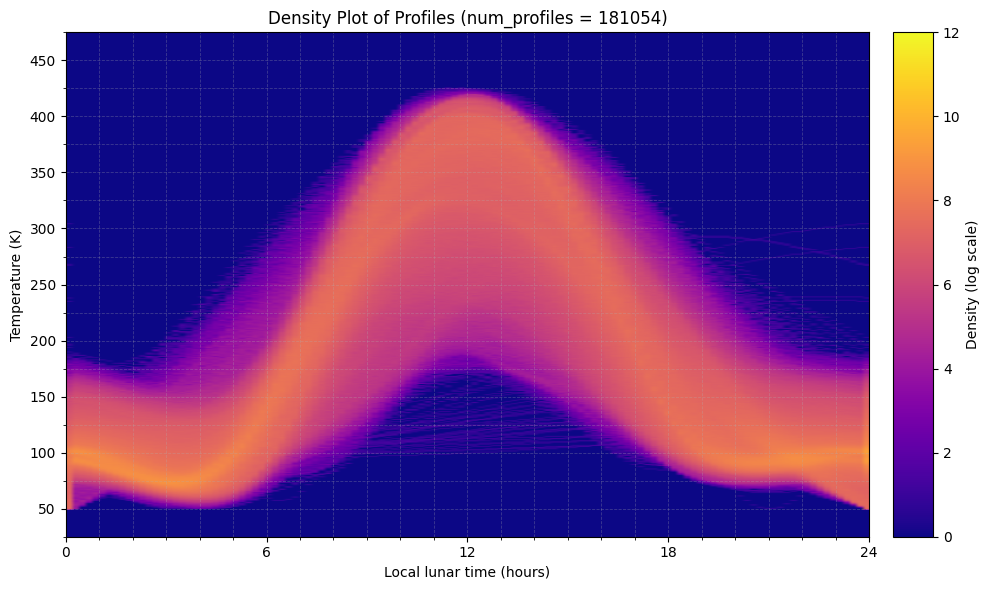

In [6]:
# * * * * * * * * * * * * * * * *
# Generate Density Plot
# * * * * * * * * * * * * * * * *
GenerateDensityPlot(temp_data, model_dir)

In [7]:
# * * * * * * * * * * * * * * * *
# Load Original Profile List
# * * * * * * * * * * * * * * * *
original_profile_list = LoadProfileList(ORIGINAL_PROFILE_LIST_JSON)

Saved figure to /workspace/outputs/profiles_v1_experiment_7_20250331_2103/histogram_max_temp.png


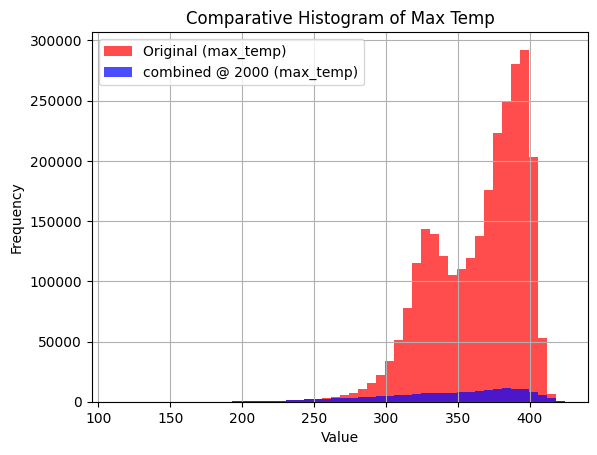

Saved figure to /workspace/outputs/profiles_v1_experiment_7_20250331_2103/histogram_min_temp.png


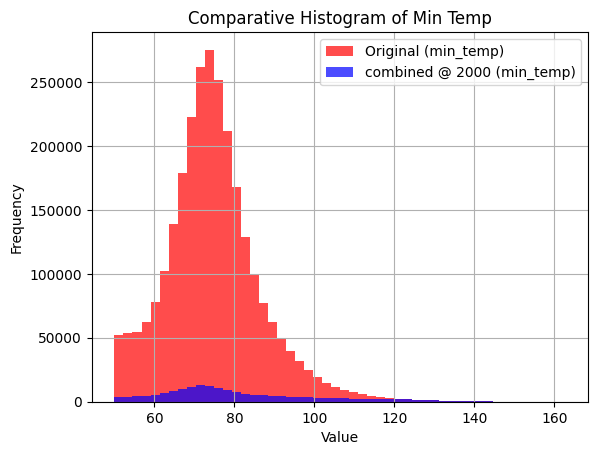

Saved figure to /workspace/outputs/profiles_v1_experiment_7_20250331_2103/histogram_mean_temp.png


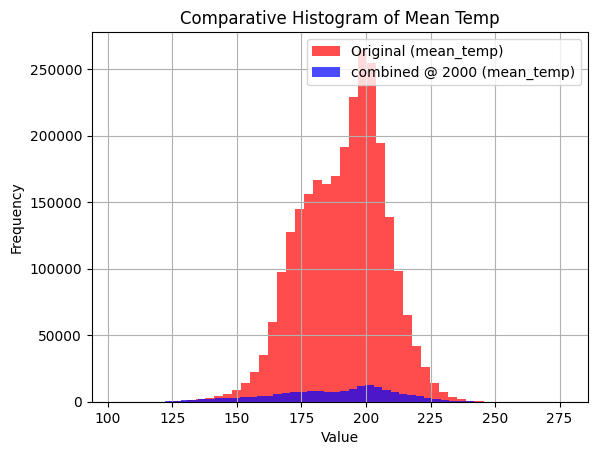

Saved figure to /workspace/outputs/profiles_v1_experiment_7_20250331_2103/histogram_std_temp.png


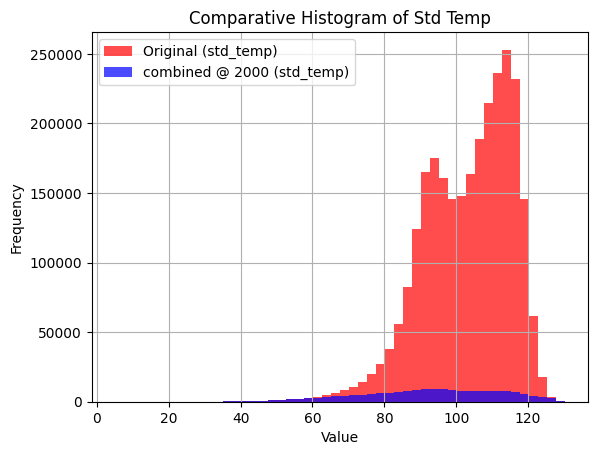

In [8]:
# * * * * * * * * * * * * * * * *
# Generate Histograms
# * * * * * * * * * * * * * * * *
statistics_original = CollectStatisticsFromProfilesV1(PROFILES_DIR, original_profile_list)
statistics_subset = CollectStatisticsFromProfilesV1(PROFILES_DIR, profile_list)
PlotComparativeHistograms(statistics_original, statistics_subset, labels=("Original", f"{TARGET_METRIC} @ {SAMPLE_SIZE}"), output_dir=model_dir)

In [9]:
# * * * * * * * * * * * * * * * *
# Training Log
# * * * * * * * * * * * * * * * 
log_filepath = os.path.join(model_dir, 'training.log')

# * * * * * * * * * * * * * * * *
# Data Prep
# * * * * * * * * * * * * * * * *
x_data_mean, x_data_std, x_data_min, x_data_max = GetDataMetrics(temp_data)

PrintAndLog(log_filepath, "Data Metrics:\n")
PrintAndLog(log_filepath, f"\tMean: {x_data_mean:.4f}\n")
PrintAndLog(log_filepath, f"\tSTD: {x_data_std:.4f}\n")
PrintAndLog(log_filepath, f"\tMin Temp: {x_data_min:.4f}\n")
PrintAndLog(log_filepath, f"\tMax Temp: {x_data_max:.4f}\n")

# Normalize Data (Mean=0, STD=1)
scaler = StandardScaler()
train_loader, val_loader, test_loader = SplitAndNormalizeData(
	temp_data, scaler, BATCH_SIZE, DEVICE)

PrintAndLog(log_filepath, "Datasets:\n")
PrintAndLog(
	log_filepath,
	f"\tTraining Data: {len(train_loader.dataset)}\n")
PrintAndLog(
	log_filepath,
	f"\tValidation Data: {len(val_loader.dataset)}\n")
PrintAndLog(log_filepath, f"\tTest Data: {len(test_loader.dataset)}\n")

Data Metrics:
Mean: 187.1439
STD: 97.6260
Min Temp: 50.0000
Max Temp: 424.9460
Datasets:
Training Data: 126737
Validation Data: 36210
Test Data: 18107


In [10]:
# * * * * * * * * * * * * * * * *
# VAE Setup
# * * * * * * * * * * * * * * * *
vae = VAE(latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE, weight_decay=0)
scheduler = ExponentialLR(optimizer, gamma=GAMMA)

summary(vae, input_size=(BATCH_SIZE, INPUT_DIM[0], INPUT_DIM[1]))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [200, 1, 120]             --
├─Encoder: 1-1                           [200, 4, 1]               --
│    └─Wrap1d: 2-1                       [200, 1, 122]             --
│    └─ConstantPad1d: 2-2                [200, 1, 128]             --
│    └─Conv1d: 2-3                       [200, 32, 128]            128
│    └─BatchNorm1d: 2-4                  [200, 32, 128]            64
│    └─Conv1d: 2-5                       [200, 32, 64]             2,080
│    └─BatchNorm1d: 2-6                  [200, 32, 64]             64
│    └─Conv1d: 2-7                       [200, 32, 32]             2,080
│    └─BatchNorm1d: 2-8                  [200, 32, 32]             64
│    └─Conv1d: 2-9                       [200, 32, 16]             2,080
│    └─BatchNorm1d: 2-10                 [200, 32, 16]             64
│    └─Conv1d: 2-11                      [200, 32, 8]              2,080
│ 

In [11]:
# * * * * * * * * * * * * * * * *
# Train and Validate
# * * * * * * * * * * * * * * * *
losses = train(
	vae, train_loader, val_loader,
	optimizer, scheduler, DEVICE, EPOCHS,
	BETA, model_dir)

[Training] Epoch 1/100: 100%|██████████| 634/634 [00:20<00:00, 31.58it/s, best_loss=0.5945]


[Training] Epoch 1/100, L1 Loss: 0.6144, L2 Loss: 0.6367, KL Loss: 0.5031, LR: 0.001000


[Validation] Epoch 1/100: 100%|██████████| 182/182 [00:01<00:00, 91.73it/s] 


[Validation] Epoch 1/100, Val L1 Loss: 0.5362, Val L2 Loss: 0.5293, Val KL Loss: 0.5781
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_7_20250331_2103'


[Training] Epoch 2/100: 100%|██████████| 634/634 [00:19<00:00, 31.91it/s, best_loss=0.5865]


[Training] Epoch 2/100, L1 Loss: 0.5667, L2 Loss: 0.5653, KL Loss: 0.5900, LR: 0.000100


[Validation] Epoch 2/100: 100%|██████████| 182/182 [00:01<00:00, 112.06it/s]


[Validation] Epoch 2/100, Val L1 Loss: 0.5217, Val L2 Loss: 0.5175, Val KL Loss: 0.5986
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_7_20250331_2103'


[Training] Epoch 3/100: 100%|██████████| 634/634 [00:20<00:00, 31.31it/s, best_loss=0.5690]


[Training] Epoch 3/100, L1 Loss: 0.5650, L2 Loss: 0.5632, KL Loss: 0.5924, LR: 0.000010


[Validation] Epoch 3/100: 100%|██████████| 182/182 [00:01<00:00, 110.89it/s]


[Validation] Epoch 3/100, Val L1 Loss: 0.5219, Val L2 Loss: 0.5179, Val KL Loss: 0.5898


[Training] Epoch 4/100: 100%|██████████| 634/634 [00:19<00:00, 32.25it/s, best_loss=0.5786]


[Training] Epoch 4/100, L1 Loss: 0.5647, L2 Loss: 0.5632, KL Loss: 0.5911, LR: 0.000001


[Validation] Epoch 4/100: 100%|██████████| 182/182 [00:01<00:00, 106.52it/s]


[Validation] Epoch 4/100, Val L1 Loss: 0.5207, Val L2 Loss: 0.5170, Val KL Loss: 0.5955
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_7_20250331_2103'


[Training] Epoch 5/100: 100%|██████████| 634/634 [00:20<00:00, 31.47it/s, best_loss=0.5681]


[Training] Epoch 5/100, L1 Loss: 0.5647, L2 Loss: 0.5630, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 5/100: 100%|██████████| 182/182 [00:01<00:00, 108.03it/s]


[Validation] Epoch 5/100, Val L1 Loss: 0.5199, Val L2 Loss: 0.5164, Val KL Loss: 0.5955
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_7_20250331_2103'


[Training] Epoch 6/100: 100%|██████████| 634/634 [00:20<00:00, 31.54it/s, best_loss=0.5718]


[Training] Epoch 6/100, L1 Loss: 0.5649, L2 Loss: 0.5631, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 6/100: 100%|██████████| 182/182 [00:01<00:00, 108.68it/s]


[Validation] Epoch 6/100, Val L1 Loss: 0.5217, Val L2 Loss: 0.5178, Val KL Loss: 0.5893


[Training] Epoch 7/100: 100%|██████████| 634/634 [00:19<00:00, 31.83it/s, best_loss=0.5417]


[Training] Epoch 7/100, L1 Loss: 0.5647, L2 Loss: 0.5631, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 7/100: 100%|██████████| 182/182 [00:01<00:00, 112.50it/s]


[Validation] Epoch 7/100, Val L1 Loss: 0.5229, Val L2 Loss: 0.5184, Val KL Loss: 0.5905


[Training] Epoch 8/100: 100%|██████████| 634/634 [00:19<00:00, 31.99it/s, best_loss=0.5653]


[Training] Epoch 8/100, L1 Loss: 0.5648, L2 Loss: 0.5631, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 8/100: 100%|██████████| 182/182 [00:01<00:00, 109.67it/s]


[Validation] Epoch 8/100, Val L1 Loss: 0.5209, Val L2 Loss: 0.5172, Val KL Loss: 0.5952


[Training] Epoch 9/100: 100%|██████████| 634/634 [00:19<00:00, 32.39it/s, best_loss=0.5534]


[Training] Epoch 9/100, L1 Loss: 0.5653, L2 Loss: 0.5635, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 9/100: 100%|██████████| 182/182 [00:01<00:00, 97.39it/s] 


[Validation] Epoch 9/100, Val L1 Loss: 0.5234, Val L2 Loss: 0.5189, Val KL Loss: 0.5879


[Training] Epoch 10/100: 100%|██████████| 634/634 [00:19<00:00, 31.84it/s, best_loss=0.5704]


[Training] Epoch 10/100, L1 Loss: 0.5648, L2 Loss: 0.5633, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 10/100: 100%|██████████| 182/182 [00:01<00:00, 109.74it/s]


[Validation] Epoch 10/100, Val L1 Loss: 0.5197, Val L2 Loss: 0.5164, Val KL Loss: 0.5967
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_7_20250331_2103'


[Training] Epoch 11/100: 100%|██████████| 634/634 [00:20<00:00, 31.59it/s, best_loss=0.5662]


[Training] Epoch 11/100, L1 Loss: 0.5653, L2 Loss: 0.5636, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 11/100: 100%|██████████| 182/182 [00:01<00:00, 110.82it/s]


[Validation] Epoch 11/100, Val L1 Loss: 0.5294, Val L2 Loss: 0.5238, Val KL Loss: 0.5735


[Training] Epoch 12/100: 100%|██████████| 634/634 [00:19<00:00, 31.71it/s, best_loss=0.5768]


[Training] Epoch 12/100, L1 Loss: 0.5649, L2 Loss: 0.5634, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 12/100: 100%|██████████| 182/182 [00:01<00:00, 116.38it/s]


[Validation] Epoch 12/100, Val L1 Loss: 0.5190, Val L2 Loss: 0.5159, Val KL Loss: 0.5964
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_7_20250331_2103'


[Training] Epoch 13/100: 100%|██████████| 634/634 [00:20<00:00, 31.31it/s, best_loss=0.5808]


[Training] Epoch 13/100, L1 Loss: 0.5649, L2 Loss: 0.5632, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 13/100: 100%|██████████| 182/182 [00:01<00:00, 114.36it/s]


[Validation] Epoch 13/100, Val L1 Loss: 0.5214, Val L2 Loss: 0.5175, Val KL Loss: 0.5894


[Training] Epoch 14/100: 100%|██████████| 634/634 [00:19<00:00, 31.99it/s, best_loss=0.5653]


[Training] Epoch 14/100, L1 Loss: 0.5651, L2 Loss: 0.5637, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 14/100: 100%|██████████| 182/182 [00:01<00:00, 122.45it/s]


[Validation] Epoch 14/100, Val L1 Loss: 0.5253, Val L2 Loss: 0.5204, Val KL Loss: 0.5807


[Training] Epoch 15/100: 100%|██████████| 634/634 [00:19<00:00, 32.77it/s, best_loss=0.5773]


[Training] Epoch 15/100, L1 Loss: 0.5649, L2 Loss: 0.5632, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 15/100: 100%|██████████| 182/182 [00:01<00:00, 114.53it/s]


[Validation] Epoch 15/100, Val L1 Loss: 0.5213, Val L2 Loss: 0.5176, Val KL Loss: 0.5946


[Training] Epoch 16/100: 100%|██████████| 634/634 [00:20<00:00, 31.64it/s, best_loss=0.5613]


[Training] Epoch 16/100, L1 Loss: 0.5647, L2 Loss: 0.5629, KL Loss: 0.5909, LR: 0.000000


[Validation] Epoch 16/100: 100%|██████████| 182/182 [00:01<00:00, 114.76it/s]


[Validation] Epoch 16/100, Val L1 Loss: 0.5236, Val L2 Loss: 0.5191, Val KL Loss: 0.5870


[Training] Epoch 17/100: 100%|██████████| 634/634 [00:20<00:00, 31.31it/s, best_loss=0.5801]


[Training] Epoch 17/100, L1 Loss: 0.5650, L2 Loss: 0.5636, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 17/100: 100%|██████████| 182/182 [00:01<00:00, 108.81it/s]


[Validation] Epoch 17/100, Val L1 Loss: 0.5212, Val L2 Loss: 0.5174, Val KL Loss: 0.5903


[Training] Epoch 18/100: 100%|██████████| 634/634 [00:19<00:00, 32.00it/s, best_loss=0.5469]


[Training] Epoch 18/100, L1 Loss: 0.5651, L2 Loss: 0.5633, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 18/100: 100%|██████████| 182/182 [00:01<00:00, 110.13it/s]


[Validation] Epoch 18/100, Val L1 Loss: 0.5209, Val L2 Loss: 0.5171, Val KL Loss: 0.5908


[Training] Epoch 19/100: 100%|██████████| 634/634 [00:20<00:00, 31.64it/s, best_loss=0.5652]


[Training] Epoch 19/100, L1 Loss: 0.5648, L2 Loss: 0.5632, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 19/100: 100%|██████████| 182/182 [00:01<00:00, 115.13it/s]


[Validation] Epoch 19/100, Val L1 Loss: 0.5261, Val L2 Loss: 0.5213, Val KL Loss: 0.5796


[Training] Epoch 20/100: 100%|██████████| 634/634 [00:19<00:00, 32.72it/s, best_loss=0.5568]


[Training] Epoch 20/100, L1 Loss: 0.5648, L2 Loss: 0.5631, KL Loss: 0.5909, LR: 0.000000


[Validation] Epoch 20/100: 100%|██████████| 182/182 [00:01<00:00, 123.14it/s]


[Validation] Epoch 20/100, Val L1 Loss: 0.5187, Val L2 Loss: 0.5155, Val KL Loss: 0.6008
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_7_20250331_2103'


[Training] Epoch 21/100: 100%|██████████| 634/634 [00:19<00:00, 32.07it/s, best_loss=0.5458]


[Training] Epoch 21/100, L1 Loss: 0.5646, L2 Loss: 0.5628, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 21/100: 100%|██████████| 182/182 [00:01<00:00, 105.44it/s]


[Validation] Epoch 21/100, Val L1 Loss: 0.5229, Val L2 Loss: 0.5187, Val KL Loss: 0.5834


[Training] Epoch 22/100: 100%|██████████| 634/634 [00:19<00:00, 31.87it/s, best_loss=0.5764]


[Training] Epoch 22/100, L1 Loss: 0.5647, L2 Loss: 0.5629, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 22/100: 100%|██████████| 182/182 [00:01<00:00, 109.68it/s]


[Validation] Epoch 22/100, Val L1 Loss: 0.5279, Val L2 Loss: 0.5224, Val KL Loss: 0.5754


[Training] Epoch 23/100: 100%|██████████| 634/634 [00:19<00:00, 32.08it/s, best_loss=0.5778]


[Training] Epoch 23/100, L1 Loss: 0.5649, L2 Loss: 0.5634, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 23/100: 100%|██████████| 182/182 [00:01<00:00, 113.38it/s]


[Validation] Epoch 23/100, Val L1 Loss: 0.5207, Val L2 Loss: 0.5169, Val KL Loss: 0.5929


[Training] Epoch 24/100: 100%|██████████| 634/634 [00:20<00:00, 31.44it/s, best_loss=0.5599]


[Training] Epoch 24/100, L1 Loss: 0.5652, L2 Loss: 0.5635, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 24/100: 100%|██████████| 182/182 [00:01<00:00, 113.79it/s]


[Validation] Epoch 24/100, Val L1 Loss: 0.5272, Val L2 Loss: 0.5218, Val KL Loss: 0.5779


[Training] Epoch 25/100: 100%|██████████| 634/634 [00:19<00:00, 32.34it/s, best_loss=0.5691]


[Training] Epoch 25/100, L1 Loss: 0.5653, L2 Loss: 0.5636, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 25/100: 100%|██████████| 182/182 [00:01<00:00, 97.41it/s] 


[Validation] Epoch 25/100, Val L1 Loss: 0.5193, Val L2 Loss: 0.5159, Val KL Loss: 0.5988


[Training] Epoch 26/100: 100%|██████████| 634/634 [00:19<00:00, 32.83it/s, best_loss=0.5695]


[Training] Epoch 26/100, L1 Loss: 0.5645, L2 Loss: 0.5629, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 26/100: 100%|██████████| 182/182 [00:01<00:00, 110.25it/s]


[Validation] Epoch 26/100, Val L1 Loss: 0.5252, Val L2 Loss: 0.5204, Val KL Loss: 0.5827


[Training] Epoch 27/100: 100%|██████████| 634/634 [00:19<00:00, 32.57it/s, best_loss=0.5674]


[Training] Epoch 27/100, L1 Loss: 0.5651, L2 Loss: 0.5634, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 27/100: 100%|██████████| 182/182 [00:01<00:00, 114.33it/s]


[Validation] Epoch 27/100, Val L1 Loss: 0.5252, Val L2 Loss: 0.5203, Val KL Loss: 0.5823


[Training] Epoch 28/100: 100%|██████████| 634/634 [00:19<00:00, 32.00it/s, best_loss=0.5697]


[Training] Epoch 28/100, L1 Loss: 0.5649, L2 Loss: 0.5630, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 28/100: 100%|██████████| 182/182 [00:01<00:00, 111.85it/s]


[Validation] Epoch 28/100, Val L1 Loss: 0.5207, Val L2 Loss: 0.5170, Val KL Loss: 0.5896


[Training] Epoch 29/100: 100%|██████████| 634/634 [00:19<00:00, 32.01it/s, best_loss=0.5805]


[Training] Epoch 29/100, L1 Loss: 0.5648, L2 Loss: 0.5631, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 29/100: 100%|██████████| 182/182 [00:01<00:00, 112.03it/s]


[Validation] Epoch 29/100, Val L1 Loss: 0.5234, Val L2 Loss: 0.5191, Val KL Loss: 0.5838


[Training] Epoch 30/100: 100%|██████████| 634/634 [00:20<00:00, 31.63it/s, best_loss=0.5826]


[Training] Epoch 30/100, L1 Loss: 0.5647, L2 Loss: 0.5630, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 30/100: 100%|██████████| 182/182 [00:01<00:00, 114.74it/s]


[Validation] Epoch 30/100, Val L1 Loss: 0.5257, Val L2 Loss: 0.5208, Val KL Loss: 0.5796


[Training] Epoch 31/100: 100%|██████████| 634/634 [00:19<00:00, 32.22it/s, best_loss=0.5665]


[Training] Epoch 31/100, L1 Loss: 0.5646, L2 Loss: 0.5627, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 31/100: 100%|██████████| 182/182 [00:01<00:00, 115.01it/s]


[Validation] Epoch 31/100, Val L1 Loss: 0.5192, Val L2 Loss: 0.5159, Val KL Loss: 0.5974


[Training] Epoch 32/100: 100%|██████████| 634/634 [00:19<00:00, 31.83it/s, best_loss=0.5568]


[Training] Epoch 32/100, L1 Loss: 0.5649, L2 Loss: 0.5632, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 32/100: 100%|██████████| 182/182 [00:01<00:00, 119.83it/s]


[Validation] Epoch 32/100, Val L1 Loss: 0.5260, Val L2 Loss: 0.5212, Val KL Loss: 0.5799


[Training] Epoch 33/100: 100%|██████████| 634/634 [00:19<00:00, 32.34it/s, best_loss=0.5895]


[Training] Epoch 33/100, L1 Loss: 0.5649, L2 Loss: 0.5634, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 33/100: 100%|██████████| 182/182 [00:01<00:00, 101.62it/s]


[Validation] Epoch 33/100, Val L1 Loss: 0.5228, Val L2 Loss: 0.5185, Val KL Loss: 0.5866


[Training] Epoch 34/100: 100%|██████████| 634/634 [00:19<00:00, 32.12it/s, best_loss=0.5834]


[Training] Epoch 34/100, L1 Loss: 0.5648, L2 Loss: 0.5631, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 34/100: 100%|██████████| 182/182 [00:01<00:00, 105.98it/s]


[Validation] Epoch 34/100, Val L1 Loss: 0.5204, Val L2 Loss: 0.5169, Val KL Loss: 0.5924


[Training] Epoch 35/100: 100%|██████████| 634/634 [00:19<00:00, 31.85it/s, best_loss=0.5827]


[Training] Epoch 35/100, L1 Loss: 0.5653, L2 Loss: 0.5638, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 35/100: 100%|██████████| 182/182 [00:01<00:00, 107.11it/s]


[Validation] Epoch 35/100, Val L1 Loss: 0.5194, Val L2 Loss: 0.5160, Val KL Loss: 0.5965


[Training] Epoch 36/100: 100%|██████████| 634/634 [00:19<00:00, 31.88it/s, best_loss=0.5901]


[Training] Epoch 36/100, L1 Loss: 0.5651, L2 Loss: 0.5635, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 36/100: 100%|██████████| 182/182 [00:01<00:00, 110.45it/s]


[Validation] Epoch 36/100, Val L1 Loss: 0.5214, Val L2 Loss: 0.5175, Val KL Loss: 0.5934


[Training] Epoch 37/100: 100%|██████████| 634/634 [00:20<00:00, 31.65it/s, best_loss=0.5528]


[Training] Epoch 37/100, L1 Loss: 0.5649, L2 Loss: 0.5631, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 37/100: 100%|██████████| 182/182 [00:01<00:00, 114.84it/s]


[Validation] Epoch 37/100, Val L1 Loss: 0.5198, Val L2 Loss: 0.5164, Val KL Loss: 0.5954


[Training] Epoch 38/100: 100%|██████████| 634/634 [00:19<00:00, 31.72it/s, best_loss=0.5569]


[Training] Epoch 38/100, L1 Loss: 0.5651, L2 Loss: 0.5635, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 38/100: 100%|██████████| 182/182 [00:01<00:00, 112.76it/s]


[Validation] Epoch 38/100, Val L1 Loss: 0.5200, Val L2 Loss: 0.5165, Val KL Loss: 0.5959


[Training] Epoch 39/100: 100%|██████████| 634/634 [00:19<00:00, 32.01it/s, best_loss=0.5626]


[Training] Epoch 39/100, L1 Loss: 0.5651, L2 Loss: 0.5637, KL Loss: 0.5912, LR: 0.000000


[Validation] Epoch 39/100: 100%|██████████| 182/182 [00:01<00:00, 110.22it/s]


[Validation] Epoch 39/100, Val L1 Loss: 0.5239, Val L2 Loss: 0.5194, Val KL Loss: 0.5853


[Training] Epoch 40/100: 100%|██████████| 634/634 [00:20<00:00, 31.53it/s, best_loss=0.5677]


[Training] Epoch 40/100, L1 Loss: 0.5650, L2 Loss: 0.5633, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 40/100: 100%|██████████| 182/182 [00:01<00:00, 114.84it/s]


[Validation] Epoch 40/100, Val L1 Loss: 0.5183, Val L2 Loss: 0.5154, Val KL Loss: 0.5998
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_7_20250331_2103'


[Training] Epoch 41/100: 100%|██████████| 634/634 [00:19<00:00, 32.12it/s, best_loss=0.5505]


[Training] Epoch 41/100, L1 Loss: 0.5651, L2 Loss: 0.5635, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 41/100: 100%|██████████| 182/182 [00:01<00:00, 95.92it/s] 


[Validation] Epoch 41/100, Val L1 Loss: 0.5230, Val L2 Loss: 0.5187, Val KL Loss: 0.5877


[Training] Epoch 42/100: 100%|██████████| 634/634 [00:19<00:00, 32.07it/s, best_loss=0.5775]


[Training] Epoch 42/100, L1 Loss: 0.5648, L2 Loss: 0.5632, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 42/100: 100%|██████████| 182/182 [00:01<00:00, 112.73it/s]


[Validation] Epoch 42/100, Val L1 Loss: 0.5233, Val L2 Loss: 0.5190, Val KL Loss: 0.5861


[Training] Epoch 43/100: 100%|██████████| 634/634 [00:20<00:00, 31.52it/s, best_loss=0.5766]


[Training] Epoch 43/100, L1 Loss: 0.5649, L2 Loss: 0.5634, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 43/100: 100%|██████████| 182/182 [00:01<00:00, 110.73it/s]


[Validation] Epoch 43/100, Val L1 Loss: 0.5233, Val L2 Loss: 0.5188, Val KL Loss: 0.5880


[Training] Epoch 44/100: 100%|██████████| 634/634 [00:19<00:00, 32.67it/s, best_loss=0.5319]


[Training] Epoch 44/100, L1 Loss: 0.5648, L2 Loss: 0.5631, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 44/100: 100%|██████████| 182/182 [00:01<00:00, 113.31it/s]


[Validation] Epoch 44/100, Val L1 Loss: 0.5208, Val L2 Loss: 0.5170, Val KL Loss: 0.5935


[Training] Epoch 45/100: 100%|██████████| 634/634 [00:20<00:00, 31.58it/s, best_loss=0.5630]


[Training] Epoch 45/100, L1 Loss: 0.5654, L2 Loss: 0.5637, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 45/100: 100%|██████████| 182/182 [00:01<00:00, 109.34it/s]


[Validation] Epoch 45/100, Val L1 Loss: 0.5238, Val L2 Loss: 0.5194, Val KL Loss: 0.5817


[Training] Epoch 46/100: 100%|██████████| 634/634 [00:19<00:00, 32.17it/s, best_loss=0.5667]


[Training] Epoch 46/100, L1 Loss: 0.5651, L2 Loss: 0.5636, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 46/100: 100%|██████████| 182/182 [00:01<00:00, 119.12it/s]


[Validation] Epoch 46/100, Val L1 Loss: 0.5241, Val L2 Loss: 0.5196, Val KL Loss: 0.5859


[Training] Epoch 47/100: 100%|██████████| 634/634 [00:19<00:00, 32.68it/s, best_loss=0.5858]


[Training] Epoch 47/100, L1 Loss: 0.5647, L2 Loss: 0.5630, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 47/100: 100%|██████████| 182/182 [00:01<00:00, 111.46it/s]


[Validation] Epoch 47/100, Val L1 Loss: 0.5243, Val L2 Loss: 0.5199, Val KL Loss: 0.5872


[Training] Epoch 48/100: 100%|██████████| 634/634 [00:19<00:00, 32.52it/s, best_loss=0.5779]


[Training] Epoch 48/100, L1 Loss: 0.5648, L2 Loss: 0.5633, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 48/100: 100%|██████████| 182/182 [00:01<00:00, 114.96it/s]


[Validation] Epoch 48/100, Val L1 Loss: 0.5253, Val L2 Loss: 0.5206, Val KL Loss: 0.5808


[Training] Epoch 49/100: 100%|██████████| 634/634 [00:19<00:00, 32.05it/s, best_loss=0.5674]


[Training] Epoch 49/100, L1 Loss: 0.5646, L2 Loss: 0.5629, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 49/100: 100%|██████████| 182/182 [00:01<00:00, 99.92it/s] 


[Validation] Epoch 49/100, Val L1 Loss: 0.5222, Val L2 Loss: 0.5182, Val KL Loss: 0.5900


[Training] Epoch 50/100: 100%|██████████| 634/634 [00:19<00:00, 32.10it/s, best_loss=0.5704]


[Training] Epoch 50/100, L1 Loss: 0.5652, L2 Loss: 0.5637, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 50/100: 100%|██████████| 182/182 [00:01<00:00, 111.98it/s]


[Validation] Epoch 50/100, Val L1 Loss: 0.5214, Val L2 Loss: 0.5176, Val KL Loss: 0.5898


[Training] Epoch 51/100: 100%|██████████| 634/634 [00:20<00:00, 31.29it/s, best_loss=0.5572]


[Training] Epoch 51/100, L1 Loss: 0.5653, L2 Loss: 0.5635, KL Loss: 0.5909, LR: 0.000000


[Validation] Epoch 51/100: 100%|██████████| 182/182 [00:01<00:00, 104.91it/s]


[Validation] Epoch 51/100, Val L1 Loss: 0.5219, Val L2 Loss: 0.5179, Val KL Loss: 0.5863


[Training] Epoch 52/100: 100%|██████████| 634/634 [00:20<00:00, 31.59it/s, best_loss=0.5430]


[Training] Epoch 52/100, L1 Loss: 0.5649, L2 Loss: 0.5632, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 52/100: 100%|██████████| 182/182 [00:01<00:00, 109.65it/s]


[Validation] Epoch 52/100, Val L1 Loss: 0.5213, Val L2 Loss: 0.5176, Val KL Loss: 0.5902


[Training] Epoch 53/100: 100%|██████████| 634/634 [00:20<00:00, 31.43it/s, best_loss=0.5813]


[Training] Epoch 53/100, L1 Loss: 0.5654, L2 Loss: 0.5639, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 53/100: 100%|██████████| 182/182 [00:01<00:00, 108.16it/s]


[Validation] Epoch 53/100, Val L1 Loss: 0.5234, Val L2 Loss: 0.5191, Val KL Loss: 0.5871


[Training] Epoch 54/100: 100%|██████████| 634/634 [00:20<00:00, 31.47it/s, best_loss=0.5561]


[Training] Epoch 54/100, L1 Loss: 0.5649, L2 Loss: 0.5633, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 54/100: 100%|██████████| 182/182 [00:01<00:00, 117.47it/s]


[Validation] Epoch 54/100, Val L1 Loss: 0.5260, Val L2 Loss: 0.5210, Val KL Loss: 0.5779


[Training] Epoch 55/100: 100%|██████████| 634/634 [00:19<00:00, 31.73it/s, best_loss=0.5709]


[Training] Epoch 55/100, L1 Loss: 0.5648, L2 Loss: 0.5632, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 55/100: 100%|██████████| 182/182 [00:01<00:00, 118.88it/s]


[Validation] Epoch 55/100, Val L1 Loss: 0.5249, Val L2 Loss: 0.5203, Val KL Loss: 0.5848


[Training] Epoch 56/100: 100%|██████████| 634/634 [00:19<00:00, 32.39it/s, best_loss=0.5685]


[Training] Epoch 56/100, L1 Loss: 0.5649, L2 Loss: 0.5633, KL Loss: 0.5909, LR: 0.000000


[Validation] Epoch 56/100: 100%|██████████| 182/182 [00:01<00:00, 112.50it/s]


[Validation] Epoch 56/100, Val L1 Loss: 0.5253, Val L2 Loss: 0.5206, Val KL Loss: 0.5808


[Training] Epoch 57/100: 100%|██████████| 634/634 [00:19<00:00, 32.05it/s, best_loss=0.5891]


[Training] Epoch 57/100, L1 Loss: 0.5652, L2 Loss: 0.5635, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 57/100: 100%|██████████| 182/182 [00:01<00:00, 97.85it/s] 


[Validation] Epoch 57/100, Val L1 Loss: 0.5178, Val L2 Loss: 0.5150, Val KL Loss: 0.5975
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_7_20250331_2103'


[Training] Epoch 58/100: 100%|██████████| 634/634 [00:19<00:00, 31.76it/s, best_loss=0.5644]


[Training] Epoch 58/100, L1 Loss: 0.5651, L2 Loss: 0.5635, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 58/100: 100%|██████████| 182/182 [00:01<00:00, 111.38it/s]


[Validation] Epoch 58/100, Val L1 Loss: 0.5208, Val L2 Loss: 0.5172, Val KL Loss: 0.5922


[Training] Epoch 59/100: 100%|██████████| 634/634 [00:19<00:00, 31.88it/s, best_loss=0.5674]


[Training] Epoch 59/100, L1 Loss: 0.5645, L2 Loss: 0.5627, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 59/100: 100%|██████████| 182/182 [00:01<00:00, 119.45it/s]


[Validation] Epoch 59/100, Val L1 Loss: 0.5197, Val L2 Loss: 0.5163, Val KL Loss: 0.5934


[Training] Epoch 60/100: 100%|██████████| 634/634 [00:19<00:00, 32.52it/s, best_loss=0.5696]


[Training] Epoch 60/100, L1 Loss: 0.5648, L2 Loss: 0.5632, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 60/100: 100%|██████████| 182/182 [00:01<00:00, 114.31it/s]


[Validation] Epoch 60/100, Val L1 Loss: 0.5232, Val L2 Loss: 0.5189, Val KL Loss: 0.5880


[Training] Epoch 61/100: 100%|██████████| 634/634 [00:19<00:00, 32.23it/s, best_loss=0.5518]


[Training] Epoch 61/100, L1 Loss: 0.5653, L2 Loss: 0.5638, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 61/100: 100%|██████████| 182/182 [00:01<00:00, 110.45it/s]


[Validation] Epoch 61/100, Val L1 Loss: 0.5219, Val L2 Loss: 0.5176, Val KL Loss: 0.5934


[Training] Epoch 62/100: 100%|██████████| 634/634 [00:20<00:00, 31.35it/s, best_loss=0.5742]


[Training] Epoch 62/100, L1 Loss: 0.5648, L2 Loss: 0.5633, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 62/100: 100%|██████████| 182/182 [00:01<00:00, 111.49it/s]


[Validation] Epoch 62/100, Val L1 Loss: 0.5218, Val L2 Loss: 0.5178, Val KL Loss: 0.5876


[Training] Epoch 63/100: 100%|██████████| 634/634 [00:19<00:00, 32.32it/s, best_loss=0.5879]


[Training] Epoch 63/100, L1 Loss: 0.5650, L2 Loss: 0.5635, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 63/100: 100%|██████████| 182/182 [00:01<00:00, 105.30it/s]


[Validation] Epoch 63/100, Val L1 Loss: 0.5177, Val L2 Loss: 0.5149, Val KL Loss: 0.6017
[Validation] Saved checkpoint in '/workspace/outputs/profiles_v1_experiment_7_20250331_2103'


[Training] Epoch 64/100: 100%|██████████| 634/634 [00:19<00:00, 32.30it/s, best_loss=0.5835]


[Training] Epoch 64/100, L1 Loss: 0.5650, L2 Loss: 0.5635, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 64/100: 100%|██████████| 182/182 [00:01<00:00, 112.94it/s]


[Validation] Epoch 64/100, Val L1 Loss: 0.5248, Val L2 Loss: 0.5198, Val KL Loss: 0.5870


[Training] Epoch 65/100: 100%|██████████| 634/634 [00:19<00:00, 32.05it/s, best_loss=0.5651]


[Training] Epoch 65/100, L1 Loss: 0.5648, L2 Loss: 0.5631, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 65/100: 100%|██████████| 182/182 [00:01<00:00, 97.77it/s] 


[Validation] Epoch 65/100, Val L1 Loss: 0.5233, Val L2 Loss: 0.5189, Val KL Loss: 0.5864


[Training] Epoch 66/100: 100%|██████████| 634/634 [00:19<00:00, 32.72it/s, best_loss=0.5550]


[Training] Epoch 66/100, L1 Loss: 0.5650, L2 Loss: 0.5635, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 66/100: 100%|██████████| 182/182 [00:01<00:00, 111.64it/s]


[Validation] Epoch 66/100, Val L1 Loss: 0.5206, Val L2 Loss: 0.5169, Val KL Loss: 0.5961


[Training] Epoch 67/100: 100%|██████████| 634/634 [00:19<00:00, 32.13it/s, best_loss=0.5589]


[Training] Epoch 67/100, L1 Loss: 0.5650, L2 Loss: 0.5634, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 67/100: 100%|██████████| 182/182 [00:01<00:00, 114.15it/s]


[Validation] Epoch 67/100, Val L1 Loss: 0.5230, Val L2 Loss: 0.5186, Val KL Loss: 0.5888


[Training] Epoch 68/100: 100%|██████████| 634/634 [00:19<00:00, 31.86it/s, best_loss=0.5622]


[Training] Epoch 68/100, L1 Loss: 0.5646, L2 Loss: 0.5626, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 68/100: 100%|██████████| 182/182 [00:01<00:00, 112.09it/s]


[Validation] Epoch 68/100, Val L1 Loss: 0.5245, Val L2 Loss: 0.5199, Val KL Loss: 0.5822


[Training] Epoch 69/100: 100%|██████████| 634/634 [00:20<00:00, 31.49it/s, best_loss=0.5809]


[Training] Epoch 69/100, L1 Loss: 0.5652, L2 Loss: 0.5634, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 69/100: 100%|██████████| 182/182 [00:01<00:00, 109.32it/s]


[Validation] Epoch 69/100, Val L1 Loss: 0.5245, Val L2 Loss: 0.5200, Val KL Loss: 0.5824


[Training] Epoch 70/100: 100%|██████████| 634/634 [00:19<00:00, 31.73it/s, best_loss=0.5674]


[Training] Epoch 70/100, L1 Loss: 0.5649, L2 Loss: 0.5633, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 70/100: 100%|██████████| 182/182 [00:01<00:00, 109.64it/s]


[Validation] Epoch 70/100, Val L1 Loss: 0.5283, Val L2 Loss: 0.5231, Val KL Loss: 0.5740


[Training] Epoch 71/100: 100%|██████████| 634/634 [00:19<00:00, 32.39it/s, best_loss=0.5848]


[Training] Epoch 71/100, L1 Loss: 0.5651, L2 Loss: 0.5635, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 71/100: 100%|██████████| 182/182 [00:01<00:00, 112.86it/s]


[Validation] Epoch 71/100, Val L1 Loss: 0.5231, Val L2 Loss: 0.5187, Val KL Loss: 0.5876


[Training] Epoch 72/100: 100%|██████████| 634/634 [00:19<00:00, 32.32it/s, best_loss=0.5725]


[Training] Epoch 72/100, L1 Loss: 0.5651, L2 Loss: 0.5633, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 72/100: 100%|██████████| 182/182 [00:01<00:00, 95.01it/s]


[Validation] Epoch 72/100, Val L1 Loss: 0.5266, Val L2 Loss: 0.5212, Val KL Loss: 0.5766


[Training] Epoch 73/100: 100%|██████████| 634/634 [00:20<00:00, 31.69it/s, best_loss=0.5724]


[Training] Epoch 73/100, L1 Loss: 0.5649, L2 Loss: 0.5632, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 73/100: 100%|██████████| 182/182 [00:01<00:00, 98.21it/s] 


[Validation] Epoch 73/100, Val L1 Loss: 0.5232, Val L2 Loss: 0.5188, Val KL Loss: 0.5875


[Training] Epoch 74/100: 100%|██████████| 634/634 [00:19<00:00, 31.87it/s, best_loss=0.5551]


[Training] Epoch 74/100, L1 Loss: 0.5650, L2 Loss: 0.5634, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 74/100: 100%|██████████| 182/182 [00:01<00:00, 112.22it/s]


[Validation] Epoch 74/100, Val L1 Loss: 0.5223, Val L2 Loss: 0.5182, Val KL Loss: 0.5896


[Training] Epoch 75/100: 100%|██████████| 634/634 [00:20<00:00, 30.89it/s, best_loss=0.5757]


[Training] Epoch 75/100, L1 Loss: 0.5650, L2 Loss: 0.5633, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 75/100: 100%|██████████| 182/182 [00:01<00:00, 108.62it/s]


[Validation] Epoch 75/100, Val L1 Loss: 0.5250, Val L2 Loss: 0.5203, Val KL Loss: 0.5814


[Training] Epoch 76/100: 100%|██████████| 634/634 [00:20<00:00, 31.66it/s, best_loss=0.5815]


[Training] Epoch 76/100, L1 Loss: 0.5651, L2 Loss: 0.5634, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 76/100: 100%|██████████| 182/182 [00:01<00:00, 108.67it/s]


[Validation] Epoch 76/100, Val L1 Loss: 0.5245, Val L2 Loss: 0.5198, Val KL Loss: 0.5869


[Training] Epoch 77/100: 100%|██████████| 634/634 [00:20<00:00, 31.58it/s, best_loss=0.5272]


[Training] Epoch 77/100, L1 Loss: 0.5650, L2 Loss: 0.5633, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 77/100: 100%|██████████| 182/182 [00:01<00:00, 107.72it/s]


[Validation] Epoch 77/100, Val L1 Loss: 0.5255, Val L2 Loss: 0.5207, Val KL Loss: 0.5819


[Training] Epoch 78/100: 100%|██████████| 634/634 [00:19<00:00, 31.95it/s, best_loss=0.5578]


[Training] Epoch 78/100, L1 Loss: 0.5654, L2 Loss: 0.5640, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 78/100: 100%|██████████| 182/182 [00:01<00:00, 112.21it/s]


[Validation] Epoch 78/100, Val L1 Loss: 0.5205, Val L2 Loss: 0.5168, Val KL Loss: 0.5938


[Training] Epoch 79/100: 100%|██████████| 634/634 [00:19<00:00, 32.43it/s, best_loss=0.5533]


[Training] Epoch 79/100, L1 Loss: 0.5648, L2 Loss: 0.5630, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 79/100: 100%|██████████| 182/182 [00:01<00:00, 112.71it/s]


[Validation] Epoch 79/100, Val L1 Loss: 0.5228, Val L2 Loss: 0.5184, Val KL Loss: 0.5883


[Training] Epoch 80/100: 100%|██████████| 634/634 [00:20<00:00, 31.52it/s, best_loss=0.5744]


[Training] Epoch 80/100, L1 Loss: 0.5650, L2 Loss: 0.5634, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 80/100: 100%|██████████| 182/182 [00:01<00:00, 112.51it/s]


[Validation] Epoch 80/100, Val L1 Loss: 0.5217, Val L2 Loss: 0.5177, Val KL Loss: 0.5913


[Training] Epoch 81/100: 100%|██████████| 634/634 [00:19<00:00, 31.91it/s, best_loss=0.5656]


[Training] Epoch 81/100, L1 Loss: 0.5649, L2 Loss: 0.5633, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 81/100: 100%|██████████| 182/182 [00:01<00:00, 96.87it/s] 


[Validation] Epoch 81/100, Val L1 Loss: 0.5234, Val L2 Loss: 0.5190, Val KL Loss: 0.5854


[Training] Epoch 82/100: 100%|██████████| 634/634 [00:19<00:00, 32.22it/s, best_loss=0.5316]


[Training] Epoch 82/100, L1 Loss: 0.5645, L2 Loss: 0.5628, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 82/100: 100%|██████████| 182/182 [00:01<00:00, 111.60it/s]


[Validation] Epoch 82/100, Val L1 Loss: 0.5190, Val L2 Loss: 0.5158, Val KL Loss: 0.5924


[Training] Epoch 83/100: 100%|██████████| 634/634 [00:19<00:00, 31.74it/s, best_loss=0.5600]


[Training] Epoch 83/100, L1 Loss: 0.5652, L2 Loss: 0.5636, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 83/100: 100%|██████████| 182/182 [00:01<00:00, 109.72it/s]


[Validation] Epoch 83/100, Val L1 Loss: 0.5226, Val L2 Loss: 0.5187, Val KL Loss: 0.5903


[Training] Epoch 84/100: 100%|██████████| 634/634 [00:19<00:00, 32.06it/s, best_loss=0.5717]


[Training] Epoch 84/100, L1 Loss: 0.5655, L2 Loss: 0.5640, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 84/100: 100%|██████████| 182/182 [00:01<00:00, 110.75it/s]


[Validation] Epoch 84/100, Val L1 Loss: 0.5194, Val L2 Loss: 0.5161, Val KL Loss: 0.5949


[Training] Epoch 85/100: 100%|██████████| 634/634 [00:19<00:00, 31.85it/s, best_loss=0.5562]


[Training] Epoch 85/100, L1 Loss: 0.5650, L2 Loss: 0.5633, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 85/100: 100%|██████████| 182/182 [00:01<00:00, 104.43it/s]


[Validation] Epoch 85/100, Val L1 Loss: 0.5229, Val L2 Loss: 0.5186, Val KL Loss: 0.5907


[Training] Epoch 86/100: 100%|██████████| 634/634 [00:19<00:00, 32.85it/s, best_loss=0.5652]


[Training] Epoch 86/100, L1 Loss: 0.5648, L2 Loss: 0.5632, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 86/100: 100%|██████████| 182/182 [00:01<00:00, 94.38it/s] 


[Validation] Epoch 86/100, Val L1 Loss: 0.5221, Val L2 Loss: 0.5182, Val KL Loss: 0.5900


[Training] Epoch 87/100: 100%|██████████| 634/634 [00:19<00:00, 32.89it/s, best_loss=0.5684]


[Training] Epoch 87/100, L1 Loss: 0.5650, L2 Loss: 0.5633, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 87/100: 100%|██████████| 182/182 [00:01<00:00, 109.35it/s]


[Validation] Epoch 87/100, Val L1 Loss: 0.5216, Val L2 Loss: 0.5175, Val KL Loss: 0.5954


[Training] Epoch 88/100: 100%|██████████| 634/634 [00:19<00:00, 31.95it/s, best_loss=0.5665]


[Training] Epoch 88/100, L1 Loss: 0.5649, L2 Loss: 0.5632, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 88/100: 100%|██████████| 182/182 [00:01<00:00, 113.69it/s]


[Validation] Epoch 88/100, Val L1 Loss: 0.5199, Val L2 Loss: 0.5165, Val KL Loss: 0.5980


[Training] Epoch 89/100: 100%|██████████| 634/634 [00:19<00:00, 32.30it/s, best_loss=0.5615]


[Training] Epoch 89/100, L1 Loss: 0.5649, L2 Loss: 0.5632, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 89/100: 100%|██████████| 182/182 [00:01<00:00, 96.76it/s] 


[Validation] Epoch 89/100, Val L1 Loss: 0.5185, Val L2 Loss: 0.5154, Val KL Loss: 0.6009


[Training] Epoch 90/100: 100%|██████████| 634/634 [00:19<00:00, 32.05it/s, best_loss=0.5718]


[Training] Epoch 90/100, L1 Loss: 0.5649, L2 Loss: 0.5633, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 90/100: 100%|██████████| 182/182 [00:01<00:00, 110.20it/s]


[Validation] Epoch 90/100, Val L1 Loss: 0.5199, Val L2 Loss: 0.5165, Val KL Loss: 0.5932


[Training] Epoch 91/100: 100%|██████████| 634/634 [00:20<00:00, 31.47it/s, best_loss=0.5768]


[Training] Epoch 91/100, L1 Loss: 0.5652, L2 Loss: 0.5635, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 91/100: 100%|██████████| 182/182 [00:01<00:00, 111.74it/s]


[Validation] Epoch 91/100, Val L1 Loss: 0.5183, Val L2 Loss: 0.5151, Val KL Loss: 0.6038


[Training] Epoch 92/100: 100%|██████████| 634/634 [00:19<00:00, 32.53it/s, best_loss=0.5779]


[Training] Epoch 92/100, L1 Loss: 0.5649, L2 Loss: 0.5632, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 92/100: 100%|██████████| 182/182 [00:01<00:00, 116.55it/s]


[Validation] Epoch 92/100, Val L1 Loss: 0.5208, Val L2 Loss: 0.5170, Val KL Loss: 0.5913


[Training] Epoch 93/100: 100%|██████████| 634/634 [00:19<00:00, 31.90it/s, best_loss=0.5625]


[Training] Epoch 93/100, L1 Loss: 0.5651, L2 Loss: 0.5633, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 93/100: 100%|██████████| 182/182 [00:01<00:00, 114.94it/s]


[Validation] Epoch 93/100, Val L1 Loss: 0.5244, Val L2 Loss: 0.5197, Val KL Loss: 0.5810


[Training] Epoch 94/100: 100%|██████████| 634/634 [00:19<00:00, 32.99it/s, best_loss=0.5670]


[Training] Epoch 94/100, L1 Loss: 0.5649, L2 Loss: 0.5632, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 94/100: 100%|██████████| 182/182 [00:01<00:00, 101.76it/s]


[Validation] Epoch 94/100, Val L1 Loss: 0.5210, Val L2 Loss: 0.5175, Val KL Loss: 0.5933


[Training] Epoch 95/100: 100%|██████████| 634/634 [00:20<00:00, 31.69it/s, best_loss=0.5597]


[Training] Epoch 95/100, L1 Loss: 0.5646, L2 Loss: 0.5629, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 95/100: 100%|██████████| 182/182 [00:01<00:00, 111.46it/s]


[Validation] Epoch 95/100, Val L1 Loss: 0.5241, Val L2 Loss: 0.5195, Val KL Loss: 0.5827


[Training] Epoch 96/100: 100%|██████████| 634/634 [00:19<00:00, 31.74it/s, best_loss=0.5765]


[Training] Epoch 96/100, L1 Loss: 0.5653, L2 Loss: 0.5636, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 96/100: 100%|██████████| 182/182 [00:01<00:00, 119.60it/s]


[Validation] Epoch 96/100, Val L1 Loss: 0.5236, Val L2 Loss: 0.5192, Val KL Loss: 0.5855


[Training] Epoch 97/100: 100%|██████████| 634/634 [00:19<00:00, 32.46it/s, best_loss=0.5631]


[Training] Epoch 97/100, L1 Loss: 0.5649, L2 Loss: 0.5632, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 97/100: 100%|██████████| 182/182 [00:01<00:00, 109.88it/s]


[Validation] Epoch 97/100, Val L1 Loss: 0.5202, Val L2 Loss: 0.5167, Val KL Loss: 0.5943


[Training] Epoch 98/100: 100%|██████████| 634/634 [00:19<00:00, 31.77it/s, best_loss=0.5666]


[Training] Epoch 98/100, L1 Loss: 0.5652, L2 Loss: 0.5635, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 98/100: 100%|██████████| 182/182 [00:01<00:00, 120.86it/s]


[Validation] Epoch 98/100, Val L1 Loss: 0.5213, Val L2 Loss: 0.5175, Val KL Loss: 0.5899


[Training] Epoch 99/100: 100%|██████████| 634/634 [00:19<00:00, 32.08it/s, best_loss=0.5864]


[Training] Epoch 99/100, L1 Loss: 0.5648, L2 Loss: 0.5633, KL Loss: 0.5911, LR: 0.000000


[Validation] Epoch 99/100: 100%|██████████| 182/182 [00:01<00:00, 103.52it/s]


[Validation] Epoch 99/100, Val L1 Loss: 0.5238, Val L2 Loss: 0.5193, Val KL Loss: 0.5842


[Training] Epoch 100/100: 100%|██████████| 634/634 [00:19<00:00, 32.17it/s, best_loss=0.5656]


[Training] Epoch 100/100, L1 Loss: 0.5647, L2 Loss: 0.5630, KL Loss: 0.5910, LR: 0.000000


[Validation] Epoch 100/100: 100%|██████████| 182/182 [00:01<00:00, 108.77it/s]

[Validation] Epoch 100/100, Val L1 Loss: 0.5213, Val L2 Loss: 0.5173, Val KL Loss: 0.5902


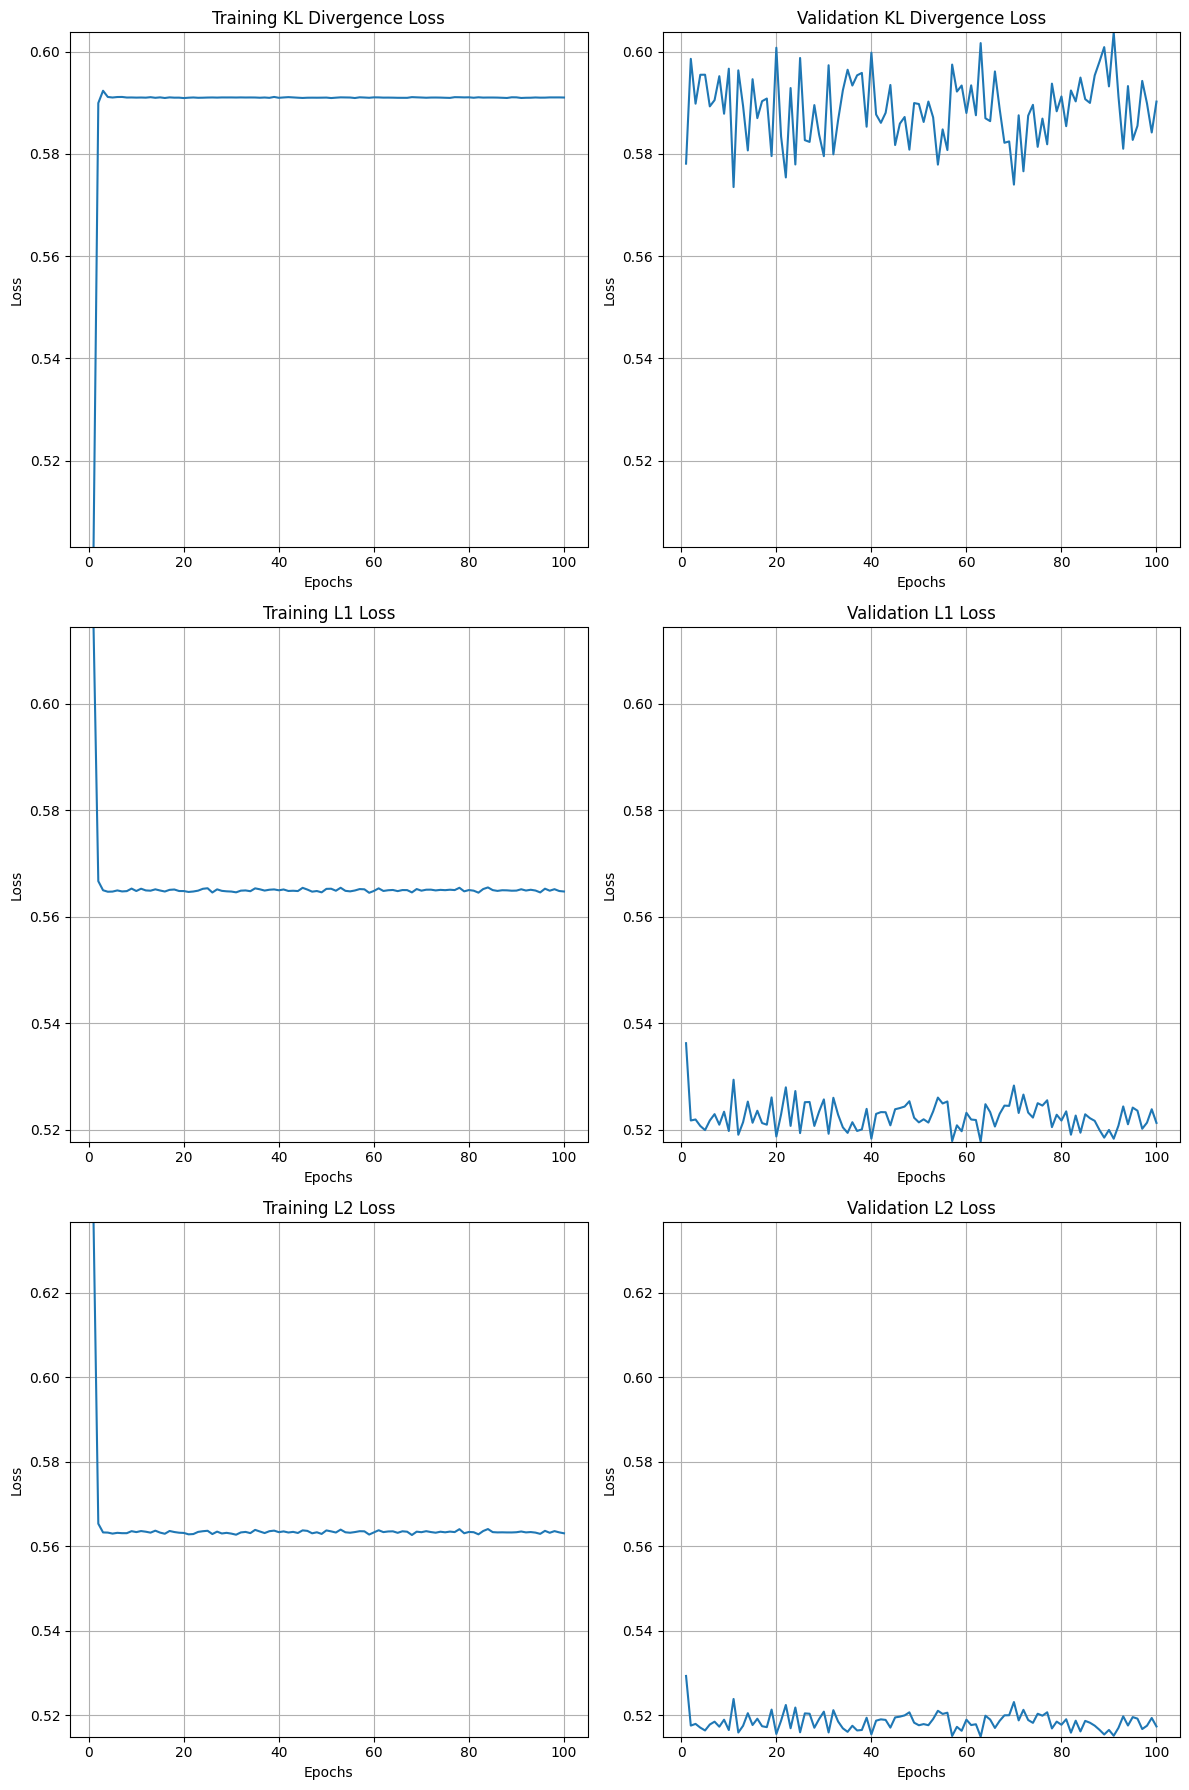

In [12]:
# * * * * * * * * * * * * * * * *
# Plot Losses
# * * * * * * * * * * * * * * * *
PlotLosses(losses, EPOCHS, model_dir)
SaveLossesToCSV(losses, os.path.join(model_dir, "losses.csv"))

In [13]:
# * * * * * * * * * * * * * * * *
# Best Validation Loss
# * * * * * * * * * * * * * * * *
PrintAndLog(log_filepath, "Best Validation Loss in Kelvins:\n")
PrintAndLog(
	log_filepath,
	f"\t{min(losses['val_l1_losses'])*x_data_std:.4f} K\n")

Best Validation Loss in Kelvins:
50.5438 K


In [14]:
# * * * * * * * * * * * * * * * *
# Sample
# * * * * * * * * * * * * * * * *
z_sample = SampleLatentSpace(
	vae,
	test_loader,
	scaler,
	DEVICE,
	model_dir
)

[Sampling]: 100%|██████████| 10/10 [00:09<00:00,  1.02it/s]


z0: -0.0339
z1: -0.0112
z2: 0.0085
z3: -0.0015


Traversing Latent Dimension z3: 100%|██████████| 11/11 [00:00<00:00, 777.98it/s]


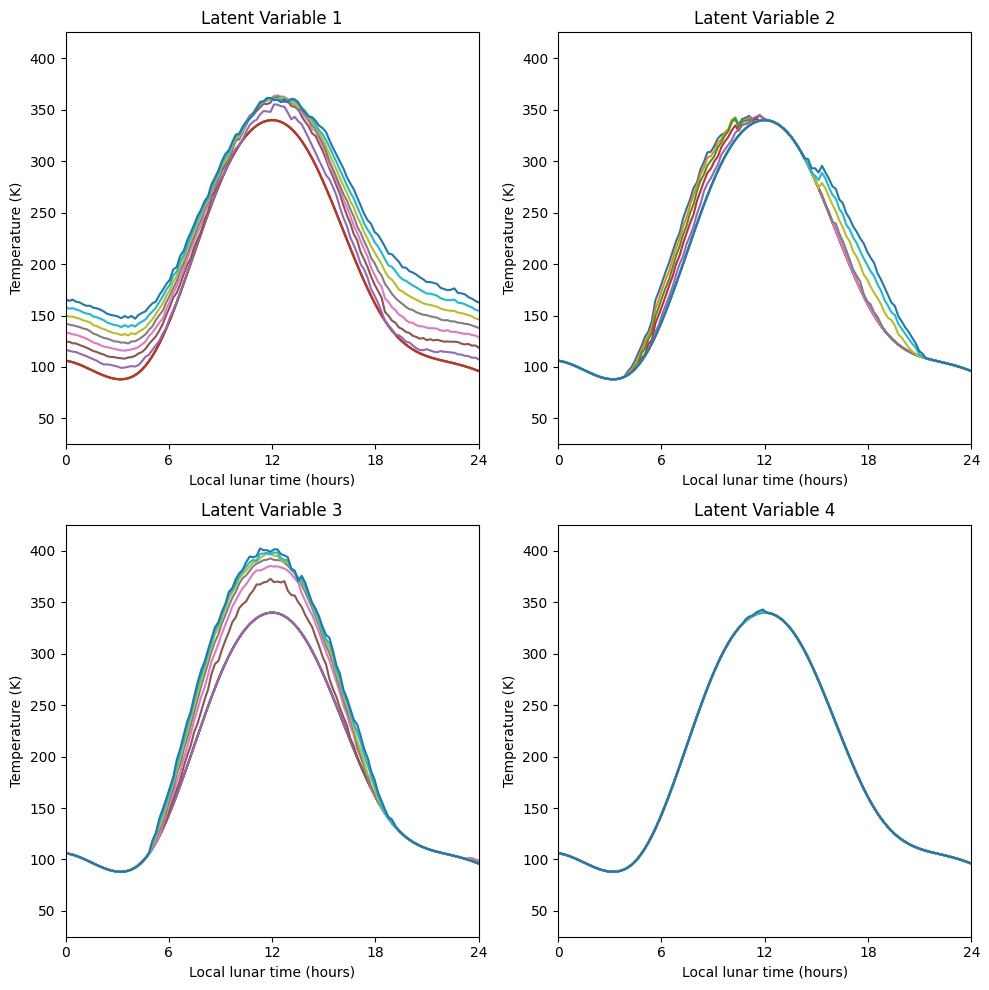

In [15]:
# * * * * * * * * * * * * * * * *
# Analyze Latent Space
# * * * * * * * * * * * * * * * *
mean_latent_vals = GetMeanLatentValues(z_sample, LATENT_DIM)
for i in range(LATENT_DIM):
	print(f"z{i}: {mean_latent_vals[i]:.4f}")

VisualizeLatentSpace(
	vae, LATENT_DIM, z_sample,
	scaler, DEVICE, model_dir)